In [1]:
# Als je `import clusterizer` typt, dan zoekt Python naar mappen en .py-bestanden met die naam.
# De plekken waar python gaat zoeken staan in de lijst `sys.path`.
# Omdat we nu in SCG-analyse/notebooks zitten, moeten we de bovenliggende map (`SCG-analyse`)
# toevoegen aan de lijst van zoekplekken.
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

# Hiermee wordt de clusterizer module herladen wanneer een bestand ervan verandert
# (handig als je aan de module aan het werken bent).
# Als je dit niet doet, wordt de code (zoals circuit.py, plot.py, etc) alleen geladen wanneer
# je `import clusterizer` typt. 
%load_ext autoreload
%autoreload 2


import clusterizer

import matplotlib.pyplot as plt

# Nodig om een np.datetime64 tijdstip (zoals in de partial_discharges DataFrame) 
# als ascoordinaat te gebruiken.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Hogere DPI voor plotjes (is mooi)
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes in inches
plt.rcParams['figure.figsize'] = [8, 5]

import pandas as pd
import numpy as np
import scipy.stats as stats

Git root path found at: C:\dev\py\SCG-analyse
Using data path:        C:\dev\py\SCG-analyse\data\origineel


In [180]:
circnum = clusterizer.globals.available_circuits[-2]

circuitje=clusterizer.circuit.MergedCircuit(circnum)
circuitje.build()

In [187]:
%%time
clusters_1d, bins, bin_counts, nom_quantile, rate = clusterizer.algorithms.clusterize_poisson_1d(circuitje, weigh_charges=False, min_bin_count=2, return_intermediate_values=True)
clusters = clusterizer.algorithms.clusterize_poisson(circuitje, magic_factor=4, min_loc_bin_count=2)

Wall time: 120 ms


In [188]:
%%time
clustersDB = clusterizer.algorithms.clusterize_DBSCAN(circuitje)

Wall time: 389 ms


In [189]:
display(clusters_1d)
display(clusters)

stats.poisson.cdf(nom_quantile, mu=rate)

{0m to 12m,
 1256m to 1272m,
 364m to 396m,
 756m to 784m,
 932m to 948m,
 976m to 988m}

{0m to 12m; 2018-08-01T19:25:00.000000000 until 2018-09-19T19:25:00.000000000,
 1256m to 1272m; 2018-07-04T19:25:00.000000000 until 2018-07-18T19:25:00.000000000,
 1256m to 1272m; 2018-08-08T19:25:00.000000000 until 2018-08-22T19:25:00.000000000,
 364m to 396m; 2018-05-30T19:25:00.000000000 until 2018-09-19T19:25:00.000000000,
 756m to 784m; 2018-07-04T19:25:00.000000000 until 2018-09-05T19:25:00.000000000,
 756m to 784m; 2018-11-21T19:25:00.000000000 until 2019-01-09T19:25:00.000000000,
 932m to 948m; 2018-07-04T19:25:00.000000000 until 2018-08-15T19:25:00.000000000,
 932m to 948m; 2018-12-05T19:25:00.000000000 until 2018-12-26T19:25:00.000000000,
 976m to 988m; 2018-08-15T19:25:00.000000000 until 2018-09-05T19:25:00.000000000,
 976m to 988m; 2018-11-28T19:25:00.000000000 until 2018-12-19T19:25:00.000000000}

0.8281930892114596

In [80]:
z = list(clusters)
np.array(z)

array( to 784m; 2018-08-08T19:25:00.000000000 until 2018-09-05T19:25:00.000000000,
       756m to 784m; 2018-11-21T19:25:00.000000000 until 2018-12-19T19:25:00.000000000,
       364m to 396m; 2018-05-30T19:25:00.000000000 until 2018-09-19T19:25:00.000000000,
       756m to 784m; 2018-07-04T19:25:00.000000000 until 2018-07-18T19:25:00.000000000,
       1256m to 1272m; 2018-07-04T19:25:00.000000000 until 2018-07-18T19:25:00.000000000,
       0m to 12m; 2018-08-08T19:25:00.000000000 until 2018-09-19T19:25:00.000000000,
       976m to 988m; 2018-08-22T19:25:00.000000000 until 2018-09-05T19:25:00.000000000],
      dtype=object)

<IPython.core.display.Javascript object>


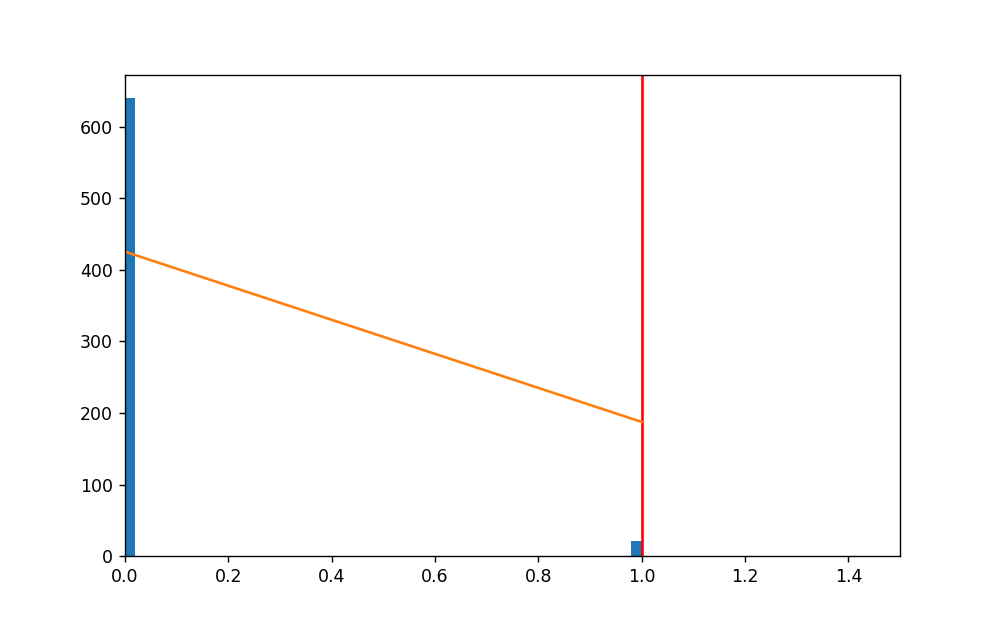

In [76]:
small_bin_counts = bin_counts[bin_counts < nom_quantile*1.5]

plt.figure()
plt.hist(small_bin_counts, bins=50)
plt.axvline(nom_quantile, c='r')
plt.xlim(0,nom_quantile*1.5)

k_samples = [int(k) for k in np.linspace(0,nom_quantile*1.5, num=100)]
plt.plot(k_samples, stats.poisson.pmf(k_samples, mu=rate) * len(small_bin_counts))

plt.show()

<IPython.core.display.Javascript object>


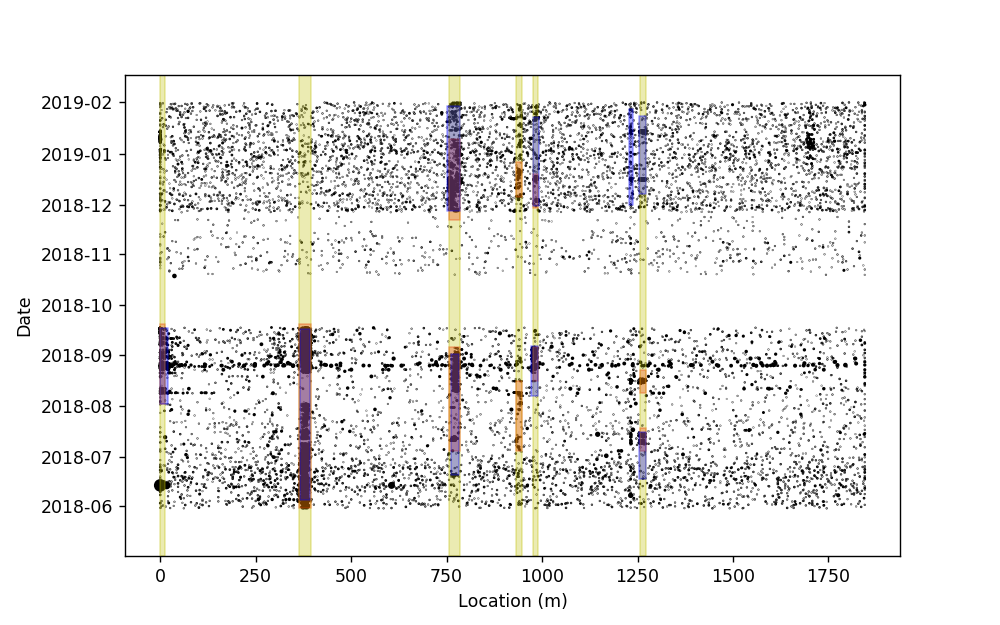

In [190]:
%matplotlib notebook

plt.figure()
clusterizer.plot.draw_location_time_scatter(circuitje)
clusterizer.plot.overlay_cluster_collection(clusters, color="r")
clusterizer.plot.overlay_cluster_collection(clusters_1d, color="y")
clusterizer.plot.overlay_cluster_collection(clustersDB, color="b")
plt.show()

In [92]:
def fast_histogram_1d(a, bins_start, bin_width, num_bins, weights=None, check_inside_bounds=True):
    if check_inside_bounds:
        inside = np.logical_and(bins_start < a, a < bins_start + (num_bins) * bin_width)
        a_inside = a[inside]
        weights_inside = None if weights is None else weights[inside]
    else:
        a_inside = a
        weights_inside = weights
    
    bin_indices = ((a_inside - bins_start) * (1.0 / bin_width)).astype(np.int64)
    return np.bincount(bin_indices, weights=weights_inside, minlength=num_bins)

In [194]:
x=np.random.rand(1000000)
weights = np.random.randn(1000000) + 5
weights = None

In [196]:
%%time
wow,_ = np.histogram(x, bins=np.linspace(0,1,num=101), weights=None)

Wall time: 66.8 ms


In [202]:
%%time
wowww = fast_histogram_1d(x, 0, 1.0/100, 100, weights=weights, check_inside_bounds=False)

Wall time: 16.9 ms


In [107]:
wow - wowww

array([-1.96450856e-10, -5.09317033e-11,  1.30967237e-10,  7.27595761e-12,
       -4.36557457e-11, -2.11002771e-10,  2.25554686e-10,  0.00000000e+00,
        2.47382559e-10, -1.45519152e-11, -7.27595761e-11, -7.27595761e-12,
       -7.27595761e-12, -6.54836185e-11, -1.09139364e-10, -2.98314262e-10,
       -2.40106601e-10, -6.54836185e-11,  5.09317033e-11, -2.18278728e-11,
        1.09139364e-10, -2.03726813e-10, -1.36788003e-09, -2.91038305e-11,
       -5.09317033e-11,  2.76486389e-10, -8.73114914e-11,  6.54836185e-11,
        2.91038305e-11, -3.49245965e-10,  3.71073838e-10, -2.83762347e-10,
        1.23691279e-10, -1.52795110e-10,  1.38243195e-10,  8.65838956e-10,
       -7.27595761e-12,  1.16415322e-10, -2.69210432e-10,  2.47382559e-10,
       -1.19325705e-09, -1.30967237e-10,  1.17870513e-09,  2.40106601e-10,
        1.41153578e-09, -3.05590220e-10,  1.46974344e-09, -3.20142135e-10,
        7.27595761e-10, -7.34871719e-10,  1.14960130e-09, -2.08092388e-09,
       -9.45874490e-11, -

In [ ]:
x = np.random.rand(10000000)

In [ ]:
%%time
wow,_ = np.histogram(x, bins=np.linspace(0,1,num=101))

In [ ]:
%%time
wowww = fast_histogram_1d(x, 0, 1.0/100, 100)

In [ ]:
wow - wowww

In [19]:
type(list(clusters)[0].time_range[0])

numpy.datetime64

In [38]:
times = circuitje.pd["Date/time (UTC)"][circuitje.pd_occured]

np.float64(times.values[0] - times.values[-1])/1000/1000/1000/60/60/24/365
times.values[0] - times.values[-1]
np.float64(times)[0]

1.52501358e+18